In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('datas/train.csv')
test_df = pd.read_csv('datas/test.csv')
store_df = pd.read_csv('datas/stores.csv')
oil_df = pd.read_csv('datas/oil.csv')
transaction_df = pd.read_csv('datas/transactions.csv')
event_df = pd.read_csv('datas/holidays_events.csv')

In [3]:
df = pd.concat((train_df.drop(["sales"], axis=1), test_df), axis=0, ignore_index=True)

In [4]:
df.shape, train_df.shape, test_df.shape

((3029400, 5), (3000888, 6), (28512, 5))

In [5]:
def show():
    show = pd.concat((df[:train_df.shape[0]], train_df[['sales']]), axis=1)
    return show
show().corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,id,store_nbr,onpromotion,sales
id,1.00,0.00,0.21,0.09
store_nbr,0.00,1.00,0.01,0.04
onpromotion,0.21,0.01,1.00,0.43
sales,0.09,0.04,0.43,1.00


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day / df['date'].dt.days_in_month
df['weekday'] = df['date'].dt.dayofweek

In [7]:
start_date = df['date'].min()
end_date = df['date'].max()
pd.date_range(start_date, end_date).difference(df['date'].unique())

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [8]:
show().corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,id,store_nbr,onpromotion,year,month,day,weekday,sales
id,1.00,0.00,0.21,0.98,0.07,0.00,-0.00,0.09
store_nbr,0.00,1.00,0.01,0.00,-0.00,-0.00,0.00,0.04
onpromotion,0.21,0.01,1.00,0.20,0.03,0.00,-0.00,0.43
year,0.98,0.00,0.20,1.00,-0.14,-0.01,-0.00,0.08
month,0.07,-0.00,0.03,-0.14,1.00,-0.01,-0.01,0.02
day,0.00,-0.00,0.00,-0.01,-0.01,1.00,0.00,-0.01
weekday,-0.00,0.00,-0.00,-0.00,-0.01,0.00,1.00,0.04
sales,0.09,0.04,0.43,0.08,0.02,-0.01,0.04,1.00


<AxesSubplot:xlabel='year'>

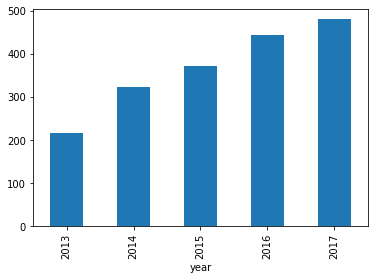

In [9]:
show().groupby('year')['sales'].mean().plot.bar()

<AxesSubplot:xlabel='month'>

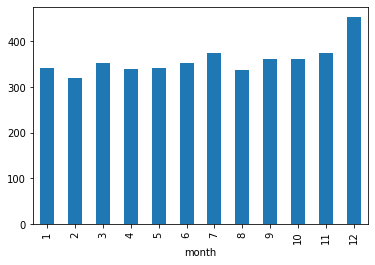

In [10]:
show().groupby('month')['sales'].mean().plot.bar()

<AxesSubplot:xlabel='day'>

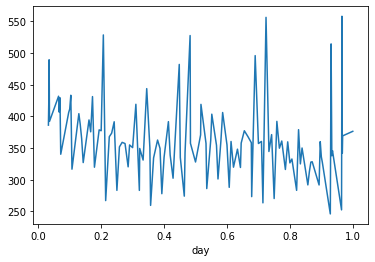

In [11]:
show().groupby('day')['sales'].mean().plot.line()

<AxesSubplot:xlabel='weekday'>

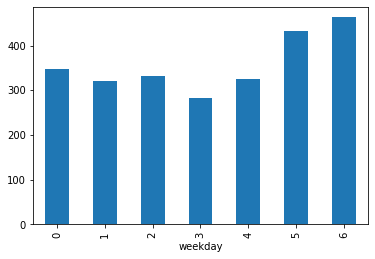

In [12]:
show().groupby('weekday')['sales'].mean().plot.bar()

In [13]:
df.shape, train_df.shape, test_df.shape

((3029400, 9), (3000888, 6), (28512, 5))

# Combine store information

In [14]:
df = pd.merge(df, store_df, on='store_nbr', how='left')

In [15]:
df.shape, train_df.shape, test_df.shape

((3029400, 13), (3000888, 6), (28512, 5))

In [16]:
df.head()

,id,date,store_nbr,family,onpromotion,year,month,day,weekday,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0,2013,1,0.032258,1,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0,2013,1,0.032258,1,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0,2013,1,0.032258,1,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0,2013,1,0.032258,1,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0,2013,1,0.032258,1,Quito,Pichincha,D,13


<AxesSubplot:xlabel='city'>

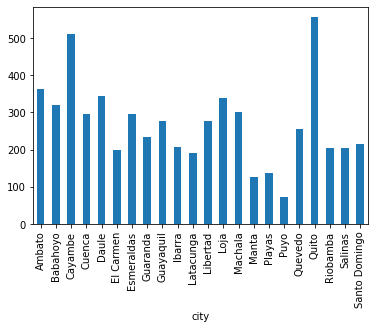

In [17]:
show().groupby('city')['sales'].mean().plot.bar()

<AxesSubplot:xlabel='cluster'>

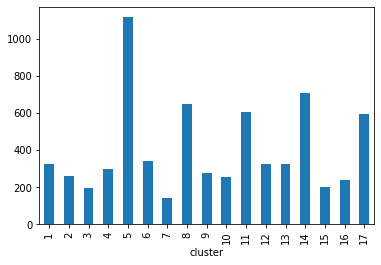

In [18]:
show().groupby('cluster')['sales'].mean().plot.bar()

<AxesSubplot:xlabel='type'>

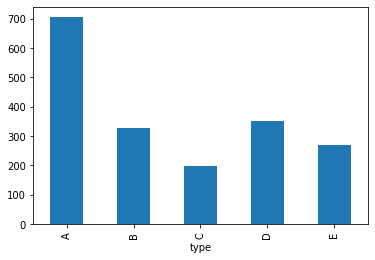

In [19]:
show().groupby('type')['sales'].mean().plot.bar()

# Process oil

In [20]:
oil_df['oil_cost'] = oil_df['dcoilwtico']
oil_df = oil_df.drop(['dcoilwtico'], axis=1)

In [21]:
oil_df['oil_cost'] = oil_df[['oil_cost']].interpolate(method='linear', limit_direction='both')

In [22]:
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df.isnull().sum()
df = pd.merge(df, oil_df, on='date', how='left')

In [23]:
df.shape, train_df.shape, test_df.shape

((3029400, 14), (3000888, 6), (28512, 5))

In [24]:
df['oil_cost'] = df[['oil_cost']].interpolate(method='linear', limit_direction='both')

# Process Holidays

In [25]:
event_df['date'] = pd.to_datetime(event_df['date'])

In [26]:
drop = event_df[event_df['transferred'] == True].index
event_df = event_df.drop(drop, axis=0)

In [27]:
event_df.loc[event_df['type']=='Transfer', 'type'] = 'Holiday'
event_df['type'].value_counts()

Holiday       221
Event          56
Additional     51
Bridge          5
Work Day        5
Name: type, dtype: int64

In [28]:
event_df['city'] = event_df['locale_name']
event_df.shape

(338, 7)

In [29]:
event_df = event_df.drop(event_df[event_df['city'] == 'Santa Elena'].index, axis=0)
event_df.shape

(332, 7)

In [30]:
event_df.loc[event_df['city']=='Santo Domingo de los Tsachilas', 'city'] = "Santo Domingo"

In [31]:
event_df = event_df.drop_duplicates(subset=['city', 'date'])

In [32]:
event_df['event_type'] = event_df['type']

In [33]:
df = pd.merge(left=df, right=event_df[['date', 'city', 'event_type']], on=['date', 'city'], how='left')

# Categorize data

<AxesSubplot:xlabel='store_nbr'>

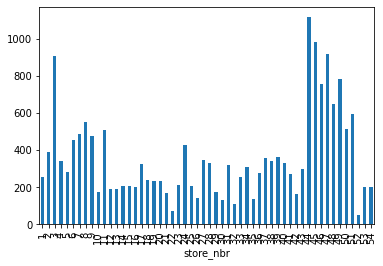

In [34]:
show().groupby('store_nbr')['sales'].mean().plot.bar()

<AxesSubplot:xlabel='onpromotion'>

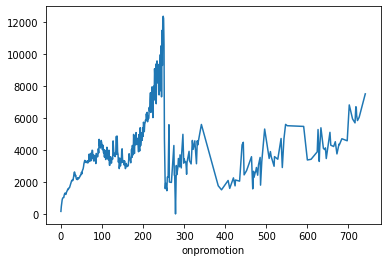

In [35]:
show().groupby('onpromotion')['sales'].mean().plot.line()

In [36]:
show().corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,id,store_nbr,onpromotion,year,month,day,weekday,cluster,oil_cost,sales
id,1.00,0.00,0.21,0.98,0.07,0.00,-0.00,-0.00,-0.84,0.09
store_nbr,0.00,1.00,0.01,0.00,-0.00,-0.00,0.00,-0.06,-0.00,0.04
onpromotion,0.21,0.01,1.00,0.20,0.03,0.00,-0.00,0.01,-0.15,0.43
year,0.98,0.00,0.20,1.00,-0.14,-0.01,-0.00,0.00,-0.83,0.08
month,0.07,-0.00,0.03,-0.14,1.00,-0.01,-0.01,0.00,0.01,0.02
day,0.00,-0.00,0.00,-0.01,-0.01,1.00,0.00,0.00,-0.00,-0.01
weekday,-0.00,0.00,-0.00,-0.00,-0.01,0.00,1.00,-0.00,0.00,0.04
cluster,-0.00,-0.06,0.01,0.00,0.00,0.00,-0.00,1.00,0.00,0.04
oil_cost,-0.84,-0.00,-0.15,-0.83,0.01,-0.00,0.00,0.00,1.00,-0.07
sales,0.09,0.04,0.43,0.08,0.02,-0.01,0.04,0.04,-0.07,1.00


In [37]:
df = pd.get_dummies(df, columns=['event_type'], dummy_na=True)

In [38]:
show().corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,id,store_nbr,onpromotion,year,month,day,weekday,cluster,oil_cost,event_type_Additional,event_type_Holiday,event_type_nan,sales
id,1.00,0.00,0.21,0.98,0.07,0.00,-0.00,-0.00,-0.84,0.01,0.00,-0.00,0.09
store_nbr,0.00,1.00,0.01,0.00,-0.00,-0.00,0.00,-0.06,-0.00,-0.01,-0.00,0.01,0.04
onpromotion,0.21,0.01,1.00,0.20,0.03,0.00,-0.00,0.01,-0.15,0.00,-0.00,-0.00,0.43
year,0.98,0.00,0.20,1.00,-0.14,-0.01,-0.00,0.00,-0.83,-0.00,-0.01,0.01,0.08
month,0.07,-0.00,0.03,-0.14,1.00,-0.01,-0.01,0.00,0.01,0.04,0.04,-0.05,0.02
day,0.00,-0.00,0.00,-0.01,-0.01,1.00,0.00,0.00,-0.00,-0.02,-0.02,0.02,-0.01
weekday,-0.00,0.00,-0.00,-0.00,-0.01,0.00,1.00,-0.00,0.00,-0.00,0.01,-0.01,0.04
cluster,-0.00,-0.06,0.01,0.00,0.00,0.00,-0.00,1.00,0.00,0.01,0.00,-0.01,0.04
oil_cost,-0.84,-0.00,-0.15,-0.83,0.01,-0.00,0.00,0.00,1.00,-0.00,-0.00,0.00,-0.07
event_type_Additional,0.01,-0.01,0.00,-0.00,0.04,-0.02,-0.00,0.01,-0.00,1.00,-0.00,-0.55,0.00


In [39]:
df = df.drop(['date', 'id'], axis=1)

In [40]:
df = pd.get_dummies(df, columns=['family'])

In [41]:
show().corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,store_nbr,onpromotion,year,month,day,weekday,cluster,oil_cost,event_type_Additional,event_type_Holiday,event_type_nan,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,sales
store_nbr,1.00,0.01,0.00,-0.00,-0.00,0.00,-0.06,-0.00,-0.01,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
onpromotion,0.01,1.00,0.20,0.03,0.00,-0.00,0.01,-0.15,0.00,-0.00,-0.00,-0.04,-0.04,-0.04,0.11,-0.04,0.02,-0.04,0.07,0.08,0.06,-0.01,-0.02,0.27,-0.04,-0.04,-0.03,-0.03,-0.04,-0.01,-0.04,-0.04,-0.04,-0.03,-0.04,0.01,0.00,-0.04,-0.04,-0.00,-0.03,0.14,-0.04,-0.03,0.43
year,0.00,0.20,1.00,-0.14,-0.01,-0.00,0.00,-0.83,-0.00,-0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08
month,-0.00,0.03,-0.14,1.00,-0.01,-0.01,0.00,0.01,0.04,0.04,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
day,-0.00,0.00,-0.01,-0.01,1.00,0.00,0.00,-0.00,-0.02,-0.02,0.02,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
weekday,0.00,-0.00,-0.00,-0.01,0.00,1.00,-0.00,0.00,-0.00,0.01,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.04
cluster,-0.06,0.01,0.00,0.00,0.00,-0.00,1.00,0.00,0.01,0.00,-0.01,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.04
oil_cost,-0.00,-0.15,-0.83,0.01,-0.00,0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.07
event_type_Additional,-0.01,0.00,-0.00,0.04,-0.02,-0.00,0.01,-0.00,1.00,-0.00,-0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
event_type_Holiday,-0.00,-0.00,-0.01,0.04,-0.02,0.01,0.00,-0.00,-0.00,1.00,-0.84,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00


In [42]:
df = pd.get_dummies(df, columns=['city', 'state', 'type'])

# Train

In [88]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

In [153]:
train_data = df[:train_df.shape[0]]
test_data = df[train_df.shape[0]:]
origin_target = train_df[['sales']]

# Simple Linear Regression

## 1. Not scaled

In [129]:
lr = LinearRegression()
lr.fit(train_data, origin_target)
train_pred = lr.predict(train_data)
train_pred = np.clip(train_pred, a_min=0, a_max=None)
np.sqrt(mean_squared_log_error(train_pred, origin_target))

2.428375393299674

## 2. Log Scaled

In [130]:
lr = LinearRegression()
lr.fit(train_data, np.log(origin_target + 1))
train_pred = np.exp(lr.predict(train_data)) - 1
train_pred = np.clip(train_pred, a_min=0, a_max=None)
np.sqrt(mean_squared_log_error(train_pred, origin_target))

1.3360396622153767

## 3. StandardScaled

In [134]:
standard_scaler = StandardScaler()
scaled_origin_target = standard_scaler.fit_transform(origin_target)

lr = LinearRegression()
lr.fit(train_data, scaled_origin_target)

train_pred = lr.predict(train_data)

train_pred = standard_scaler.inverse_transform(train_pred)
train_pred = np.clip(train_pred, a_min=0, a_max=None)

np.sqrt(mean_squared_log_error(train_pred, origin_target))

2.428390387281812

# Classify 0, 1 First

In [245]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

In [233]:
is_zero = pd.DataFrame(origin_target)
is_zero.loc[origin_target['sales'] == 0, 'sales'] = True
is_zero.loc[origin_target['sales'] != 0, 'sales'] = False
origin_target = train_df[['sales']]

In [234]:
is_zero = is_zero.astype(int)
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(train_data, is_zero, test_size=0.1)

In [247]:
hgb = HistGradientBoostingClassifier()
hgb.fit(bin_X_train, bin_y_train['sales'])

HistGradientBoostingClassifier()

In [248]:
bin_pred = hgb.predict(bin_X_test)
accuracy_score(bin_pred, bin_y_test)

0.9440299377851238

In [249]:
from sklearn.model_selection import KFold

In [250]:
sales_model = HistGradientBoostingRegressor()

In [251]:
not_zero_X = train_data.loc[origin_target['sales']!=0]
not_zero_y = origin_target.loc[origin_target['sales']!=0]
not_zero_y = np.log(not_zero_y['sales'] + 1)

In [253]:
cv = KFold(n_splits=3, shuffle=True)

In [254]:
param_grid = {
    'max_iter': [500],
    'n_iter_no_change': [10],
    'learning_rate': [0.05],
    'max_depth': [7, 9],
    'min_samples_leaf': [10, 30],
    'l2_regularization': [0.1],
}

gsv = GridSearchCV(sales_model, param_grid=param_grid, verbose=3, refit=True, cv=cv)
gsv.fit(not_zero_X, not_zero_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END l2_regularization=0.1, learning_rate=0.05, max_depth=7, max_iter=500, min_samples_leaf=10, n_iter_no_change=10;, score=0.957 total time= 1.2min
[CV 2/3] END l2_regularization=0.1, learning_rate=0.05, max_depth=7, max_iter=500, min_samples_leaf=10, n_iter_no_change=10;, score=0.955 total time= 1.2min
[CV 3/3] END l2_regularization=0.1, learning_rate=0.05, max_depth=7, max_iter=500, min_samples_leaf=10, n_iter_no_change=10;, score=0.956 total time= 1.2min
[CV 1/3] END l2_regularization=0.1, learning_rate=0.05, max_depth=7, max_iter=500, min_samples_leaf=30, n_iter_no_change=10;, score=0.957 total time= 1.1min
[CV 2/3] END l2_regularization=0.1, learning_rate=0.05, max_depth=7, max_iter=500, min_samples_leaf=30, n_iter_no_change=10;, score=0.956 total time= 1.2min
[CV 3/3] END l2_regularization=0.1, learning_rate=0.05, max_depth=7, max_iter=500, min_samples_leaf=30, n_iter_no_change=10;, score=0.956 total time= 1.1mi

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=HistGradientBoostingRegressor(),
             param_grid={'l2_regularization': [0.1], 'learning_rate': [0.05],
                         'max_depth': [7, 9], 'max_iter': [500],
                         'min_samples_leaf': [10, 30],
                         'n_iter_no_change': [10]},
             verbose=3)

In [257]:
test_data = test_data.drop("index", axis=1)

In [258]:
pred_is_zero = hgb.predict(test_data)

In [259]:
submit = pd.DataFrame({
    'id': test_df['id'],
    'sales': pred_is_zero,
})

In [260]:
zero_idx = submit[submit['sales'] == 1].index
non_zero_idx = submit[submit['sales'] == 0].index

In [261]:
submit.loc[zero_idx, 'sales'] = 0

In [263]:
data_non_zero = test_data.loc[non_zero_idx]

In [264]:
pred_non_zero = gsv.best_estimator_.predict(data_non_zero)

In [265]:
pred_non_zero = np.exp(pred_non_zero) - 1
pred_non_zero = np.clip(pred_non_zero, a_min=0, a_max=None)

In [266]:
submit.loc[non_zero_idx, 'sales'] = pred_non_zero

In [267]:
submit

,id,sales
0,3000888,3.963314
1,3000889,0.000000
2,3000890,7.248654
3,3000891,2460.423444
4,3000892,0.000000
...,...,...
28507,3029395,294.699314
28508,3029396,76.652672
28509,3029397,1313.521297
28510,3029398,40.651957


In [268]:
submit.to_csv('outputs/separate.csv',index=False)